## A comparison between Pytorch ,TVM and Auto-TVM for natural language proccessing with googls BERT model

In [1]:
# I sometimes need to choose PyTorch...
import timeit
import numpy as np
import inspect
import sys
#sys.path.insert(0, '/home/tv/pytorch/pytorch/build/lib.linux-x86_64-3.8//')
import torch
import torch.utils.dlpack

# import TVM
import sys
import os


tvm_root = '/home/tv/rocm/tvm/tvm/'
tvm_paths = [os.path.join(tvm_root, p) for p in ['python', 'topi/python', 'nnvm/python']]
os.environ['PYTHONPATH'] = ':'.join([os.environ.get('PYTHONPATH', '')] + tvm_paths)
for p in tvm_paths:
    sys.path.insert(0, p)
    

import tvm
import tvm.relay

torch.cuda.get_device_name()

'NVIDIA GeForce RTX 2080 Ti'

## Fetch the model
The model we are using is basic but functional. Also we are not here for training classification models so we will use the pretrained resnet-18.

In [2]:
import transformers

from transformers import BertModel, BertTokenizer, BertConfig
import numpy

import torch

import tvm.contrib.graph_executor as runtime


enc = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenizing input text
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]" 
tokenized_text = enc.tokenize(text)

# Masking one of the input tokens
masked_index = 8
tokenized_text[masked_index] = '[MASK]'
indexed_tokens = enc.convert_tokens_to_ids(tokenized_text)
# segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
segments_ids = [0] * tokenized_text.index("[SEP]") + [1] * (len(tokenized_text) - tokenized_text.index("[SEP]"))

batch_size = 15
tokens_tensor = torch.tensor([indexed_tokens] * batch_size) 
segments_tensors = torch.tensor([segments_ids] * batch_size)
dummy_input = [tokens_tensor, segments_tensors]

# If you are instantiating the model with `from_pretrained` you can also easily set the TorchScript flag
model = BertModel.from_pretrained("bert-base-uncased", torchscript=True)

model.eval()
for p in model.parameters():
    p.requires_grad_(False)

with torch.cuda.amp.autocast():
    res_pt = model(tokens_tensor, segments_tensors)

torch.cuda.synchronize()



In [3]:
traced_model = torch.jit.trace(model, [tokens_tensor, segments_tensors])
traced_model.eval()
for p in traced_model.parameters():
    p.requires_grad_(False)

/home1/public/misampson/miniconda3/envs/tvm/lib/python3.11/site-packages/transformers/modeling_utils.py:4481: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


In [4]:
def run_pytorch(model, tt_c, st_c):
    res_pt = model(tt_c, st_c)
    return res_pt

In [5]:
def timit(func, *args, **kwargs):
    timing_number = 10
    timing_repeat = 10
    
    warmup_results = timeit.repeat(lambda: func(*args, **kwargs), repeat=timing_repeat, number=timing_number)
    timing_results = timeit.repeat(lambda: func(*args, **kwargs), repeat=timing_repeat, number=timing_number)
    
    timing_summary = {
        "mean": sum(timing_results) / len(timing_results),
        "median": sorted(timing_results)[len(timing_results)//2],
        "std": np.std(timing_results),
    }
    
    print("Timing Summary:")
    print(timing_summary)
    return timing_summary


In [6]:
model.cuda()
tt_c = tokens_tensor.cuda()
st_c = segments_tensors.cuda()
res_pt = run_pytorch(model,tt_c, st_c)
torch.cuda.synchronize()

In [7]:
import sqlite3

# Define the path to the SQLite database file
db_path = 'timing_results.db'

# Connect to the SQLite database (creates the file if it doesn't exist)
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Create a table with the specified schema
create_table_query = '''
CREATE TABLE IF NOT EXISTS timing_results (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    device TEXT NOT NULL,
    batch_size INTEGER NOT NULL,
    runner TEXT NOT NULL,
    time REAL NOT NULL
)
'''
cursor.execute(create_table_query)
conn.commit()

def insert_timing_result(device, batch_size, runner, time):
    # Check for an existing record
    select_query = '''
    SELECT id, time FROM timing_results
    WHERE device = ? AND batch_size = ? AND runner = ?
    '''
    cursor.execute(select_query, (device, batch_size, runner))
    result = cursor.fetchone()
    
    if result:
        existing_id, existing_time = result
        # Update the record if the new time is better (lower)
        if time < existing_time:
            update_query = '''
            UPDATE timing_results
            SET time = ?
            WHERE id = ?
            '''
            cursor.execute(update_query, (time, existing_id))
            conn.commit()
    else:
        # Insert a new record
        insert_query = '''
        INSERT INTO timing_results (device, batch_size, runner, time)
        VALUES (?, ?, ?, ?)
        '''
        cursor.execute(insert_query, (device, batch_size, runner, time))
        conn.commit()


In [8]:

time = timit(run_pytorch,model, tt_c ,st_c)

insert_timing_result('cuda', batch_size, 'PyTorch', time['mean'])

Timing Summary:
{'mean': 0.08527804473415017, 'median': 0.0853012939915061, 'std': 0.0005743827534891931}


In [9]:
shape_list = [(i.debugName().split('.')[0], i.type().sizes()) for i in  list(traced_model.graph.inputs())[1:]]
shape_list
mod_bert, params_bert = tvm.relay.frontend.pytorch.from_pytorch(traced_model,
                        shape_list, default_dtype="float32")
target = tvm.target.Target("cuda")
ctx = tvm.cuda(0)
target_host = 'llvm'


tt_a = tvm.nd.array(tokens_tensor.numpy(), ctx)
st_a = tvm.nd.array(segments_tensors.numpy(), ctx)

In [10]:
import tvm.contrib.graph_executor as runtime
torch.cuda.empty_cache()
# tvm.relay.backend.compile_engine.get().clear() # just to be sure, see https://github.com/apache/incubator-tvm/pull/5724
tvm.relay.backend.te_compiler.get().clear()

with tvm.transform.PassContext(opt_level=3):
        graph, lib, params = tvm.relay.build(mod_bert,
                                     target=target,
                                     params=params_bert)
module = runtime.create(graph, lib, ctx)

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.
/tmp/ipykernel_24990/2465543736.py:7: DeprecationWarning: legacy graph executor behavior of producing json / lib / params will be removed in the next release. Please see documents of tvm.contrib.graph_executor.GraphModule for the  new recommended usage.
  graph, lib, params = tvm.relay.build(mod_bert,


In [11]:
def run_module(mod):
    mod.run()
    return mod

In [12]:
module.set_input("input_ids", tt_a)
module.set_input("attention_mask", st_a)
module.set_input(**params)
run_module(module)

output_0 = module.get_output(0).asnumpy()
output_1 = module.get_output(1).asnumpy()

# print("Output 0:", output_0)
# print("Output 1:", output_1)

# # Compare results
# print(numpy.abs((res_pt[0].cpu().numpy() - output_0)).max())
# print(numpy.abs((res_pt[1].cpu().numpy() - output_1)).max())



In [13]:

tvm_wo_autotune_time=timit(run_module,module)
insert_timing_result('cuda', batch_size, 'TVM', tvm_wo_autotune_time['mean'])


Timing Summary:
{'mean': 0.6927605931647122, 'median': 0.6926706917583942, 'std': 0.0003016734121966062}


Now extract the tune

In [14]:
tasks = tvm.autotvm.task.extract_from_program(mod_bert["main"], target=target, params=params)


## Begin TVM steps




In [15]:
import sqlite3
from pathlib import Path
def model_exists_in_db(device, model, batch_size):
    db_path = '/home1/public/misampson/resnet-50/git/ITE-Forth-CARV/tvm_report/automate_tvm.db'
    
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    query = '''
    SELECT COUNT(*) FROM device_models
    WHERE device = ? AND model = ? AND batch_size = ?
    '''
    
    cursor.execute(query, (device, model, batch_size))
    result = cursor.fetchone()
    
    conn.close()
    
    return result[0] > 0


In [16]:
log_filename = 'bert-tuning.log'

In [17]:
n_trial = 1000  # for real tuning, make this 2000!

def do_tune(tasks, log_filename):
    tmp_log_file = log_filename + ".tmp"
    for i, tsk in enumerate(reversed(tasks)):
        prefix = "[Task %2d/%2d] " %(i+1, len(tasks))

        # we use threading and tornado here to work around TVM and Jupyter colliding over IOLoops
        # In a regular python command line, you should be able to just call the tuner...
        import threading 
        import tornado

        # create tuner
        tuner = tvm.autotvm.tuner.XGBTuner(tsk, loss_type='rank',feature_type='itervar')
        if os.path.isfile(tmp_log_file):
            tuner.load_history(tvm.autotvm.record.load_from_file(tmp_log_file))

        # do tuning
        tsk_trial = min(n_trial, len(tsk.config_space))
        def tune_task_fn():
            iol = tornado.ioloop.IOLoop()  # we need an event loop
            tuner.tune(
                n_trial=n_trial,
                early_stopping=600,
                measure_option=tvm.autotvm.measure_option(
                    builder=tvm.autotvm.LocalBuilder(timeout=10),
                    runner=tvm.autotvm.LocalRunner(number=20, repeat=3, timeout=4, min_repeat_ms=150)),
                callbacks=[
                    tvm.autotvm.callback.progress_bar(tsk_trial, prefix=prefix),
                    tvm.autotvm.callback.log_to_file(tmp_log_file)
                ])

        tuning_thread = threading.Thread(target=tune_task_fn)  # create a thread start it and wait on it
        tuning_thread.start()
        tuning_thread.join()
        # done tuning, on to the next task

    # pick best records to a cache file
    tvm.autotvm.record.pick_best(tmp_log_file, log_filename)
if model_exists_in_db("cuda", "bert", batch_size) :
    print("already tuned")
else:
    do_tune(tasks, log_filename)
    

[Task  1/ 6]  Current/Best:  855.43/ 855.43 GFLOPS | Progress: (18/18) | 35.78 s Done.
[Task  2/ 6]  Current/Best: 3371.13/3883.70 GFLOPS | Progress: (608/1000) | 1453.99 s Done.
[Task  3/ 6]  Current/Best: 3685.84/3896.92 GFLOPS | Progress: (1000/1000) | 2424.65 s Done.
[Task  4/ 6]  Current/Best:  792.60/1681.77 GFLOPS | Progress: (800/1000) | 1217.88 s Done.
[Task  5/ 6]  Current/Best:  160.49/1057.17 GFLOPS | Progress: (816/1000) | 1230.03 s Done.
[Task  6/ 6]  Current/Best: 2586.92/3573.88 GFLOPS | Progress: (608/1000) | 1176.10 s Done.


In [18]:
def serealize_lib_to_database(device, model, batch_size, lib):
    db_path = '/home1/public/misampson/resnet-50/git/ITE-Forth-CARV/tvm_report/automate_tvm.db'
    ##### Path Lib Construction #####
    lib_path = f'/home1/public/misampson/resnet-50/git/ITE-Forth-CARV/tvm_report/automated_database/{device}/{model}/{batch_size}'
    # Ensure the directory exists
    os.makedirs(lib_path, exist_ok=True)

    ##### Serialization #####
    # Serialize the library
    file_name = "deploy.so"
    path_lib = os.path.join(lib_path, file_name)
    lib.export_library(path_lib)

    # Save paths to the SQLite database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Insert data into the table
    cursor.execute('''
    INSERT INTO device_models (device, model, batch_size)
    VALUES (?, ?, ?)
    ''', (device, model, batch_size))
    
    conn.commit()  # Save (commit) the changes
    conn.close() 

def fetch_lib():
    filepath = f'/home1/public/misampson/resnet-50/git/ITE-Forth-CARV/tvm_report/automated_database/cuda/{model}/{batch_size}'
    print("Load lib from database...")
    so_files = list(Path(filepath).glob('*.so'))
    if not so_files:
        raise ValueError(f"No .so files found in {filepath}")
    path_lib = str(so_files[0])
    lib = tvm.runtime.load_module(path_lib)
    
    return lib

In [19]:
# tvm.relay.backend.compile_engine.get().clear()
torch.cuda.empty_cache()
if model_exists_in_db("cuda", "bert", batch_size) :
    lib=fetch_lib()
    module = graph_executor.GraphModule(lib["default"](ctx))
else:
    tvm.relay.backend.te_compiler.get().clear()
    with tvm.autotvm.apply_history_best(log_filename):
        with tvm.transform.PassContext(opt_level=3):
            graph, lib, params = tvm.relay.build(mod_bert,
                                         target=target,
                                         params=params_bert)
    serealize_lib_to_database("cuda", "bert", batch_size, lib)
    
    module = runtime.create(graph, lib, ctx)


/tmp/ipykernel_24990/89043758.py:10: DeprecationWarning: legacy graph executor behavior of producing json / lib / params will be removed in the next release. Please see documents of tvm.contrib.graph_executor.GraphModule for the  new recommended usage.
  graph, lib, params = tvm.relay.build(mod_bert,


In [20]:
torch.cuda.empty_cache()

module = runtime.create(graph, lib, ctx)

In [26]:
module.set_input("input_ids", tt_a)
module.set_input("attention_mask", st_a)
module.set_input(**params)
run_module(module)
o0 = module.get_output(0)
o1 = module.get_output(1)
(numpy.abs((res_pt[0].cpu().numpy() - o0.asnumpy())).max(), 
 numpy.abs((res_pt[1].cpu().numpy() - o1.asnumpy())).max())

tvm_w_autotune_time=timit(run_module,module)
insert_timing_result('cuda', batch_size, 'AutoTune', tvm_w_autotune_time['mean'])


Timing Summary:
{'mean': 0.10860270205885172, 'median': 0.10860567539930344, 'std': 2.0562109207352628e-05}


##### 

In [31]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

def get_timing_results_from_db(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    query = "SELECT batch_size, runner, time FROM timing_results"
    cursor.execute(query)
    rows = cursor.fetchall()
    conn.close()

    timing_results_dict = {}
    for batch_size, runner, mean_time in rows:
        runner_lower = runner.lower()  # Convert runner to lowercase
        if runner_lower not in timing_results_dict:
            timing_results_dict[runner_lower] = []
        timing_results_dict[runner_lower].append((batch_size, mean_time))

    # Sort results by batch size
    for runner in timing_results_dict:
        timing_results_dict[runner].sort(key=lambda x: x[0])

    return timing_results_dict

def plot_timing_results(timing_results_dict, model):
    if not timing_results_dict:
        print("No timing results provided.")
        return

    plt.figure(figsize=(12, 8))  # Adjust figsize if needed

    runners = list(timing_results_dict.keys())
    batch_sizes = sorted(set(size for results in timing_results_dict.values() for size, _ in results))
    x_ticks = np.arange(len(batch_sizes))
    
    # Define colors for different runners (PyTorch, TVM, Autotune, etc.)
    color_map = {'pytorch': 'orange', 'tvm': 'lightblue', 'autotune': 'darkblue'}

    # Plot vertical bars for mean timing results
    for i, runner in enumerate(runners):
        timing_results = timing_results_dict[runner]
        timing_means = [mean for _, mean in timing_results]
        batch_sizes = [size for size, _ in timing_results]
        
        for j, (mean, size) in enumerate(zip(timing_means, batch_sizes)):
            plt.bar(x_ticks[j] + i * 0.2, mean, color=color_map.get(runner, 'black'), width=0.2)
            # plt.text(x_ticks[j] + i * 0.2, mean, f'{mean:.3f}s', ha='center', va='bottom', color='black', fontsize=8)

    # Set x-axis ticks and labels
    plt.xticks(x_ticks, batch_sizes, fontsize=12)

    plt.title('Execution on Nvidia GPU 2080ti', fontsize=40)
    plt.xlabel('Batch Size', fontsize=26)
    plt.ylabel('Mean Execution Time (seconds)', fontsize=26)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    # Define custom legend labels and handles with corresponding colors
    custom_handles = [plt.Rectangle((0,0),1,1, color=color_map[runner]) for runner in runners]
    custom_labels = runners
    
    # Display legend with custom labels and handles
    plt.legend(custom_handles, custom_labels, loc='upper left', fontsize=24)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()



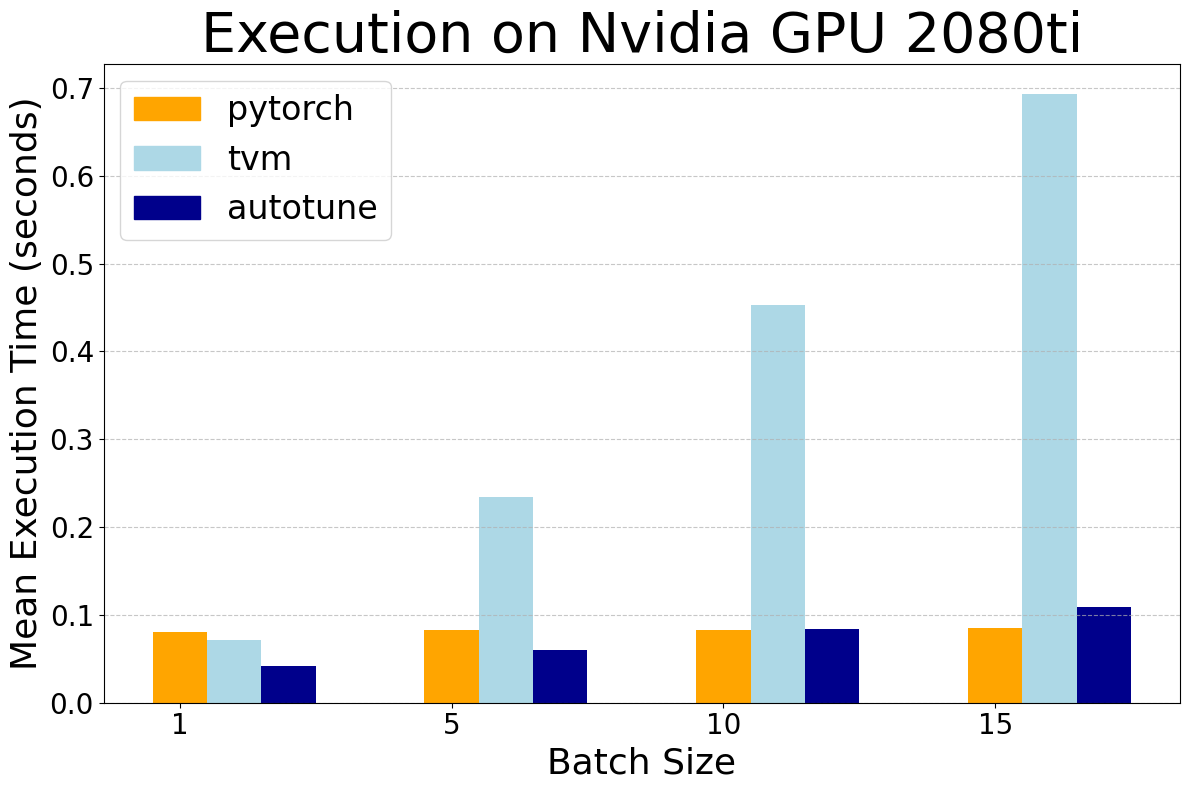

In [32]:

# Example usage
db_path = 'timing_results.db'
timing_results_dict = get_timing_results_from_db(db_path)
plot_timing_results(timing_results_dict, model='bert')


In [ ]:
def tvm_relay_with_file(network, batch_size):
    tuning_logs_dir = "/home1/public/misampson/resnet-50/git/ITE-Forth-CARV/tuning-logs"
    log_dir = f"log{batch_size}"
    logfile_path = os.path.join(tuning_logs_dir, "tune_nn/longer-tune", log_dir, "resnet-18.log")
    
    mod, params, input_shape, out_shape = get_network(network, batch_size)
    
    with autotvm.apply_history_best(logfile_path):
        with tvm.transform.PassContext(opt_level=3):
            lib = relay.build(mod, target=target, params=params)
    
    # Load the compiled module onto the device
    dev = tvm.device(str(target), 0)
    module = runtime.GraphModule(lib["default"](dev))
    return module

def save_mean_time(batch_size, mean_time):
    with open(f'autotune_all_timing_batch_{batch_size}.txt', 'w') as f:
        f.write(str(mean_time))

def get_timing_results(batch_sizes):
    timing_results = []
    for batch_size in batch_sizes:
        with open(f'autotune_all_timing_batch_{batch_size}.txt', 'r') as f:
            mean_time = float(f.read())
        timing_results.append((batch_size, mean_time))
    return timing_results
    
batch_size=256
# module = tvm_relay_with_file(network, batch_size)

In [ ]:

 tvm_w_autotune_time=timit(run_module,module)
# mean_time = tvm_wo_autotune_time["mean"]
# save_mean_time(batch_size, mean_time)

In [123]:
import threading
import time
import numpy as np
import matplotlib.pyplot as plt

def execute_and_plot_autotune_timit():
    global tvm_lib, tvm_inp_name
    batch_sizes = [1, 10, 100, 200, 256]
    timing_results = []

    for batch_size in batch_sizes:
        module = tvm_relay_with_file(network, batch_size)
        tvm_wo_autotune_time=timit(run_module,module)
        mean_time = tvm_wo_autotune_time["mean"]
        save_mean_time(batch_size, mean_time)

    timing_results = get_timing_results(batch_sizes)  # Retrieve timing results from saved files
    plot_timing_results(timing_results)


def save_mean_time(batch_size, mean_time):
    with open(f'autotune_timing_batch_{batch_size}.txt', 'w') as f:
        f.write(str(mean_time))

def get_timing_results(batch_sizes):
    timing_results = []
    for batch_size in batch_sizes:
        with open(f'autotune_timing_batch_{batch_size}.txt', 'r') as f:
            mean_time = float(f.read())
        timing_results.append((batch_size, mean_time))
    return timing_results

def plot_timing_results(timing_results):
    # Remove None values from timing_results
    timing_results = [result for result in timing_results if result is not None]

    if not timing_results:
        print("No timing results to plot.")
        return

    timing_results.sort(key=lambda x: x[1])  # Sort by mean time
    batch_sizes = [result[0] for result in timing_results]  # Extract batch sizes
    timing_means = [result[1] for result in timing_results]  # Extract timing results

    plt.figure(figsize=(10, 6))

    # Generate equally spaced y-axis ticks
    y_ticks = np.arange(len(batch_sizes))

    # Plot horizontal bars for mean timing results
    colors = plt.cm.viridis(np.linspace(0, 1, len(batch_sizes)))  # Generate different colors
    for i, (mean, size) in enumerate(zip(timing_means, batch_sizes)):
        plt.barh(y_ticks[i], mean, color=colors[i], label=f'Batch Size {size}')

    # Set y-axis ticks and labels
    plt.yticks(y_ticks, batch_sizes)

    plt.title('PyTorch Mean Execution Time vs Batch Size')
    plt.xlabel('Mean Execution Time (seconds)')
    plt.ylabel('Batch Size')
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Remove background grid lines
    plt.gca().invert_yaxis()  # Invert y-axis to have the smallest batch size at the top
    plt.tight_layout()
    plt.show()

# Usage
#execute_and_plot_autotune_timit()


In [ ]:
# tvm_autotune_time=timit(run_module,module)

In [ ]:
def plot_timestamps(time1, time2, time3):
    # Parse the timestamps to extract mean, median, and standard deviation values
    def parse_timestamp(timestamp):
        if timestamp is None:
            return None, None, None
        return timestamp["mean"], timestamp["median"], timestamp["std"]

    t1_mean, t1_median, t1_std = parse_timestamp(time1)
    t2_mean, t2_median, t2_std = parse_timestamp(time2)
    t3_mean, t3_median, t3_std = parse_timestamp(time3)

    # Plotting
    labels = ['Mean', 'Median', 'Std']
    t1_values = [t1_mean, t1_median, t1_std]
    t2_values = [t2_mean, t2_median, t2_std]
    t3_values = [t3_mean, t3_median, t3_std]

    x = range(len(labels))
    width = 0.2

    fig, ax = plt.subplots()
    bars = []
    
    if t1_mean is not None:
        bars.append(ax.bar(x, t1_values, width, label='Pytorch'))
    if t2_mean is not None:
        bars.append(ax.bar([i + width for i in x], t2_values, width, label='TVM without tuning'))
    if t3_mean is not None:
        bars.append(ax.bar([i + width*2 for i in x], t3_values, width, label='TVM autotune'))

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Time')
    ax.set_title('Classification Timing Comparison')
    ax.set_xticks([i + width for i in x])
    ax.set_xticklabels(labels)
    
    # Add legend only if there are bars plotted
    if bars:
        ax.legend()

    plt.show()

In [ ]:
# plot_timestamps(pytorch_time, tvm_wo_autotune_time, tvm_autotune_time)

In [ ]:

def mean_timestamps(time1, time2, time3):
    # Parse the timestamps to extract mean values
    def parse_timestamp(timestamp):
        if timestamp is None:
            return None
        return timestamp["mean"]

    t1_mean = parse_timestamp(time1)
    t2_mean = parse_timestamp(time2)
    t3_mean = parse_timestamp(time3)

    # Plotting
    labels = ['Pytorch', 'TVM without tuning', 'TVM autotune']
    means = [t1_mean, t2_mean, t3_mean]

    x = range(len(labels))
    width = 0.5

    fig, ax = plt.subplots()
    bars = []

    if t1_mean is not None:
        bars.append(ax.bar(x[0], t1_mean, width, label='Pytorch'))
    if t2_mean is not None:
        bars.append(ax.bar(x[1], t2_mean, width, label='TVM without tuning'))
    if t3_mean is not None:
        bars.append(ax.bar(x[2], t3_mean, width, label='TVM autotune'))

    ax.set_xlabel('Frameworks')
    ax.set_ylabel('Mean Time')
    ax.set_title('Mean Classification Time Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Add the mean value on top of each bar
    for bar in bars:
        for b in bar:
            height = b.get_height()
            ax.annotate(f'{height:.4f}',
                        xy=(b.get_x() + b.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    plt.show()

In [ ]:
# mean_timestamps(pytorch_time, tvm_wo_autotune_time, tvm_autotune_time)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_timing_results(file_prefixes, batch_sizes):
    timing_results_list = []
    for file_prefix in file_prefixes:
        timing_results = []
        for batch_size in batch_sizes:
            file_path = f'{file_prefix}{batch_size}.txt'
            try:
                with open(file_path, 'r') as f:
                    mean_time = float(f.read())
                timing_results.append((batch_size, mean_time))
            except FileNotFoundError:
                pass  # Skip if file not found for the current batch size
        timing_results_list.append(timing_results)
    return timing_results_list

def plot_timing_results(timing_results_list, labels, model, dataset):
    if not timing_results_list or not labels:
        print("No timing results or labels provided.")
        return
    
    plt.figure(figsize=(12, 8))  # Adjust figsize if needed

    # Generate equally spaced x-axis ticks
    x_ticks = np.arange(len(timing_results_list[0]))
    
    # Define colors for PyTorch, TVM, and autotune
    color_map = {'PyTorch': 'orange', 'TVM': 'lightblue', 'Autotune': 'darkblue'}
    
    # Plot vertical bars for mean timing results
    for i, (timing_results, label) in enumerate(zip(timing_results_list, labels)):
        timing_means = [result[1] for result in timing_results]
        batch_sizes = [result[0] for result in timing_results]
        
        for j, (mean, size) in enumerate(zip(timing_means, batch_sizes)):
            plt.bar(x_ticks[j] + i * 0.2, mean, color=color_map.get(label, 'black'), width=0.2)
            #plt.text(x_ticks[j] + i * 0.2, mean, f'{mean:.3f}s', ha='center', va='bottom', color='black', fontsize=8)

    # Set x-axis ticks and labels
    if 256 in batch_sizes:
        batch_sizes = [size for size in batch_sizes if size != 256] + [256]  # Move batch size 256 to the end
    plt.xticks(x_ticks + 0.2 * len(timing_results_list) / 2, batch_sizes, fontsize=12)

    plt.title('Execution on Nvidia GPU 2080ti', fontsize=36)
    plt.xlabel('Batch Size', fontsize=24)
    plt.ylabel('Mean Execution Time (seconds)', fontsize=24)
    
    # Define custom legend labels and handles with corresponding colors
    custom_handles = [plt.Rectangle((0,0),1,1, color=color_map[label]) for label in labels]
    custom_labels = labels
    
    # Display legend with custom labels and handles
    plt.legend(custom_handles, custom_labels, loc='upper left', fontsize=12)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Example usage
file_prefixes = ['pytorch_timing_batch_', 'tvm_timing_batch_', 'autotune_timing_batch_']
labels = ['PyTorch', 'TVM', 'Autotune']
batch_sizes = [1, 10, 100, 200, 256] 
timing_results_list = get_timing_results(file_prefixes, batch_sizes)
plot_timing_results(timing_results_list, labels, model='ResNet-18', dataset='ImageNet')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_timing_results(file_prefixes, batch_size):
    timing_results_list = []
    for file_prefix in file_prefixes:
        file_path = f'{file_prefix}{batch_size}.txt'
        try:
            with open(file_path, 'r') as f:
                mean_time = float(f.read())
            timing_results_list.append((batch_size, mean_time))
        except FileNotFoundError:
            timing_results_list.append((batch_size, None))  # Use None for missing values
    return timing_results_list

def plot_timing_results(timing_results_list, labels, model, dataset):
    if not timing_results_list or not labels:
        print("No timing results or labels provided.")
        return
    
    plt.figure(figsize=(12, 8))  # Adjust figsize if needed

    # Define colors for PyTorch, TVM, Autotune, and Autotune_all
    color_map = {'PyTorch': 'orange', 'TVM': 'lightblue', 'Autotune': 'darkblue', 'Autotune_all': 'purple'}
    
    # Plot vertical bars for mean timing results
    batch_size, _ = timing_results_list[0]  # All results should have the same batch size
    x_ticks = np.arange(1)  # Only one batch size

    # Set bar width and spacing
    bar_width = 0.05  # Thinner bars
    spacing = 0.02  # Less spacing

    for i, ((_, mean), label) in enumerate(zip(timing_results_list, labels)):
        if mean is not None:  # Only plot if mean is available
            plt.bar(x_ticks + i * (bar_width + spacing), mean, color=color_map.get(label, 'black'), width=bar_width)
            plt.text(x_ticks + i * (bar_width + spacing), mean, f'{mean:.3f}s', ha='center', va='bottom', color='black', fontsize=8)

    # Set x-axis ticks and labels
    plt.xticks([0.1], [batch_size], fontsize=12)  # Adjust position to align with thinner bars

    plt.title('Execution on Nvidia GPU 2080ti', fontsize=36)
    plt.xlabel('Batch Size', fontsize=24)
    plt.ylabel('Mean Execution Time (seconds)', fontsize=24)
    
    # Define custom legend labels and handles with corresponding colors
    custom_handles = [plt.Rectangle((0,0),1,1, color=color_map[label]) for label in labels]
    custom_labels = ['PyTorch', 'TVM', 'Autotune_conv2d', 'Autotune_all']  # Updated legend label
    
    # Display legend with custom labels and handles
    plt.legend(custom_handles, custom_labels, loc='upper left', fontsize=12)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Example usage
file_prefixes = ['pytorch_timing_batch_', 'tvm_timing_batch_', 'autotune_timing_batch_', 'autotune_all_timing_batch_']
labels = ['PyTorch', 'TVM', 'Autotune', 'Autotune_all']
batch_size = 256 
timing_results_list = get_timing_results(file_prefixes, batch_size)
plot_timing_results(timing_results_list, labels, model='ResNet-18', dataset='ImageNet')


In [ ]:
def tvm_relay_with_file(network, batch_size, logfile_path):
    mod, params, input_shape, out_shape = get_network(network, batch_size)
    if logfile_path:
        with autotvm.apply_history_best(logfile_path):
            with tvm.transform.PassContext(opt_level=3):
                lib = relay.build(mod, target=target, params=params)
    else:
        with tvm.transform.PassContext(opt_level=3):
                lib = relay.build(mod, target=target, params=params)
        
    # Load the compiled module onto the device
    dev = tvm.device(str(target), 0)
    module = runtime.GraphModule(lib["default"](dev))
    return module


batch_size=50
# Run TVM relay with two different log files
logfile_path_conv2d = "/home1/public/misampson/resnet-50/git/ITE-Forth-CARV/tuning-logs/longer-tune/log256/conv2d/vit_conv2d.log"
logfile_path_all = "/home1/public/misampson/resnet-50/git/ITE-Forth-CARV/tuning-logs/longer-tune/log256/all/vit.log"

# Generate modules
module_base = tvm_relay_with_file('vit', batch_size, None)
module_conv2d = tvm_relay_with_file('vit', batch_size, logfile_path_conv2d)
module_all = tvm_relay_with_file('vit', batch_size, logfile_path_all)

# Dummy mean times: Replace these with actual measured times
mean_pytorch = pytime['mean']
mean_time_base= timit(run_module, module_base)['mean']
mean_time_conv2d = timit(run_module, module_conv2d)['mean']
mean_time_all = timit(run_module, module_all)['mean']

# Save the mean times to variables instead of files
timing_results_list = [
    (batch_size, mean_pytorch),
    (batch_size, mean_time_base),
    (batch_size, mean_time_conv2d),
    (batch_size, mean_time_all)
]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_timing_results(timing_results_list, labels, model, dataset):
    if not timing_results_list or not labels:
        print("No timing results or labels provided.")
        return

    plt.figure(figsize=(12, 8))  # Adjust figsize if needed

    # Define colors for PyTorch, TVM, Autotune_conv2d, and Autotune_all
    color_map = {
        'PyTorch': 'orange', 
        'TVM': 'lightblue', 
        'Autotune_conv2d': 'darkblue', 
        'Autotune_all': 'purple'
    }
    
    # Ensure PyTorch is the first label and its timing results are first in the list
    if 'PyTorch' not in labels:
        print("PyTorch timing results not provided.")
        return

    if labels[0] != 'PyTorch':
        pytorch_index = labels.index('PyTorch')
        labels.insert(0, labels.pop(pytorch_index))
        timing_results_list.insert(0, timing_results_list.pop(pytorch_index))

    # Plot vertical bars for mean timing results
    batch_size, _ = timing_results_list[0]  # All results should have the same batch size
    x_ticks = np.arange(1)  

    # Set bar width and spacing
    bar_width = 0.1  # Thinner bars
    spacing = 0.2  # Less spacing

    for i, ((_, mean), label) in enumerate(zip(timing_results_list, labels)):
        if mean is not None:  # Only plot if mean is available
            plt.bar(x_ticks + i * (bar_width + spacing), mean, color=color_map.get(label, 'black'), width=bar_width)
            plt.text(x_ticks + i * (bar_width + spacing), mean, f'{mean:.3f}s', ha='center', va='bottom', color='black', fontsize=8)

    # Set x-axis ticks and labels
    plt.xticks([0.1], [50], fontsize=12)  # Adjust position to align with thinner bars

    plt.title(f'Execution on Nvidia GPU 2080ti\nModel: {model}, Dataset: {dataset}', fontsize=24)
    plt.xlabel('Batch Size', fontsize=24)
    plt.ylabel('Mean Execution Time (seconds)', fontsize=24)
    
    # Define custom legend labels and handles with corresponding colors
    custom_handles = [plt.Rectangle((0,0),1,1, color=color_map[label]) for label in labels]
    custom_labels = labels  # Use provided labels directly
    
    # Display legend with custom labels and handles
    plt.legend(custom_handles, custom_labels, loc='upper center', fontsize=12)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Example usage:
labels = ['PyTorch', 'TVM', 'Autotune_conv2d', 'Autotune_all']
plot_timing_results(timing_results_list, labels, model='vit', dataset='ImageNet')
